In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")
stores = pd.read_csv("data/stores.csv") 
oil = pd.read_csv("data/oil.csv")     
holiday_events = pd.read_csv("data/holidays_events.csv")     
transactions = pd.read_csv("data/transactions.csv")

In [ ]:
# Convert dates
holiday_events['date'] = pd.to_datetime(holiday_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

# Convert holiday_events types
holiday_events['type'] = holiday_events['type'].astype('category')
holiday_events['locale'] = holiday_events['locale'].astype('category')
holiday_events['locale_name'] = holiday_events['locale_name'].astype('category')
holiday_events['description'] = holiday_events['description'].astype(str)
holiday_events['transferred'] = holiday_events['transferred'].astype(bool)

# Convert oil
oil['dcoilwtico'] = pd.to_numeric(oil['dcoilwtico'], errors='coerce')

# Convert stores
stores['store_nbr'] = stores['store_nbr'].astype('int32')
stores['city'] = stores['city'].astype('category')
stores['state'] = stores['state'].astype('category')
stores['type'] = stores['type'].astype('category')
stores['cluster'] = stores['cluster'].astype('int8')

# Convert train
train['id'] = train['id'].astype('int32')
train['store_nbr'] = train['store_nbr'].astype('int32')
train['family'] = train['family'].astype('category')
train['sales'] = pd.to_numeric(train['sales'], downcast='float')
train['onpromotion'] = pd.to_numeric(train['onpromotion'], downcast='integer')

# Convert test
test['id'] = test['id'].astype('int32')
test['store_nbr'] = test['store_nbr'].astype('int32')
test['family'] = test['family'].astype('category')
test['onpromotion'] = pd.to_numeric(test['onpromotion'], downcast='integer')

# Convert transactions
transactions['store_nbr'] = transactions['store_nbr'].astype('int32')
transactions['transactions'] = pd.to_numeric(transactions['transactions'], downcast='integer')



In [ ]:
import pandas as pd
# Interpolate missing oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate().fillna(method='bfill')

# Prepare holiday subsets
holidays = holiday_events[['date', 'locale', 'locale_name', 'type']].copy()
nat_holidays = holidays[holidays['locale'] == 'National'][['date', 'type']].rename(columns={'type': 'nat_holiday'})
reg_holidays = holidays[holidays['locale'] == 'Regional'][['date', 'locale_name', 'type']].rename(columns={'locale_name': 'state', 'type': 'reg_holiday'})
loc_holidays = holidays[holidays['locale'] == 'Local'][['date', 'locale_name', 'type']].rename(columns={'locale_name': 'city', 'type': 'loc_holiday'})

# Merge all data
train_merged = train.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(nat_holidays, on='date', how='left')
train_merged = train_merged.merge(reg_holidays, on=['date', 'state'], how='left')
train_merged = train_merged.merge(loc_holidays, on=['date', 'city'], how='left')

# Create unified holiday flag
train_merged['is_holiday'] = (
    train_merged['nat_holiday'].notna() |
    train_merged['reg_holiday'].notna() |
    train_merged['loc_holiday'].notna()
).astype(int)

# Fill missing transactions
train_merged['transactions'] = train_merged['transactions'].fillna(0)

# Create time features
train_merged['dayofweek'] = pd.to_datetime(train_merged['date']).dt.dayofweek
train_merged['month'] = pd.to_datetime(train_merged['date']).dt.month
train_merged['year'] = pd.to_datetime(train_merged['date']).dt.year
train_merged['is_weekend'] = train_merged['dayofweek'].isin([5, 6]).astype(int)


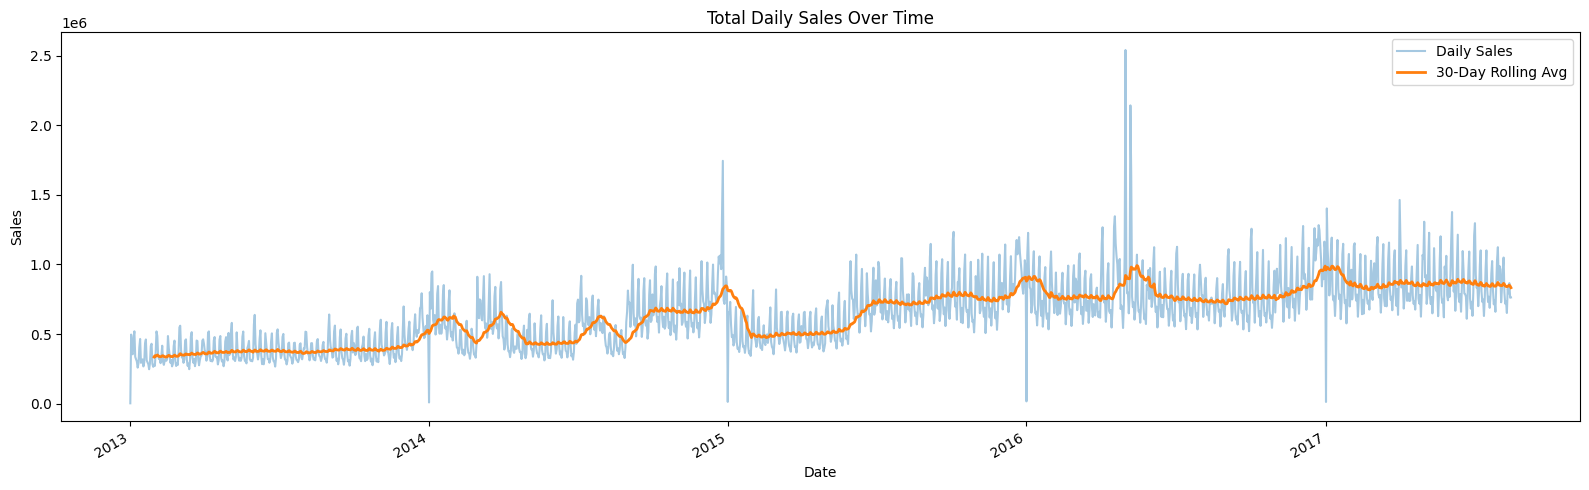

In [21]:
daily_sales = train_merged.groupby('date')['sales'].sum()

plt.figure(figsize=(16, 5))
daily_sales.plot(alpha=0.4, label='Daily Sales')
daily_sales.rolling(30).mean().plot(label='30-Day Rolling Avg', linewidth=2)

plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


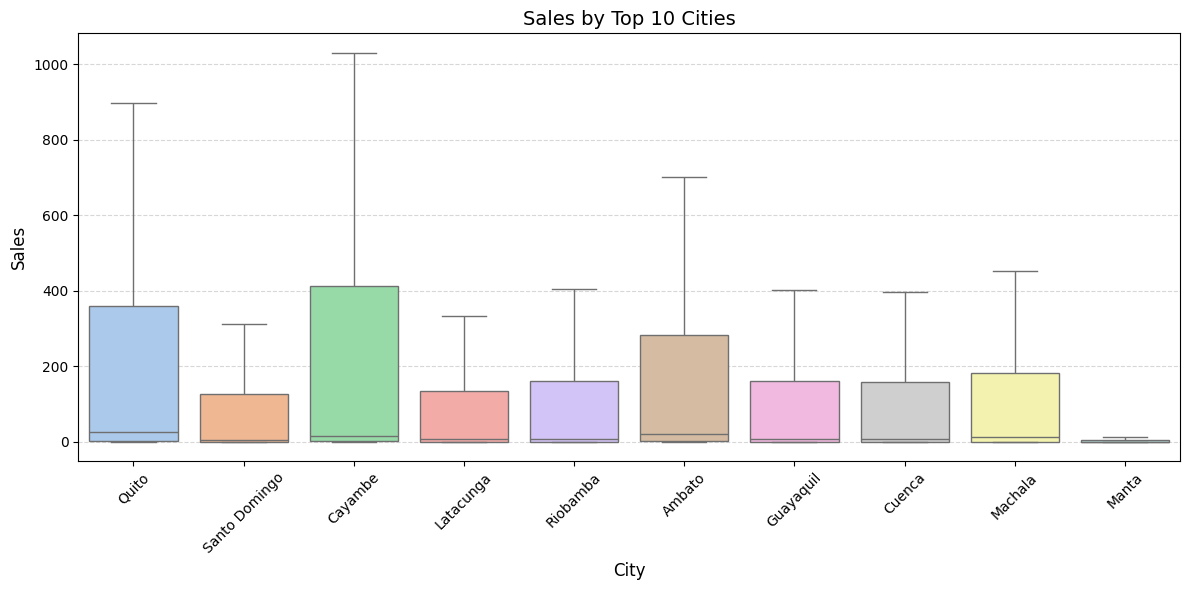

In [23]:
top_cities = train_merged['city'].value_counts().head(10).index
filtered = train_merged[train_merged['city'].isin(top_cities)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='city',
    y='sales',
    hue='city',           # explicitly set hue to suppress warning
    data=filtered,
    palette='pastel',
    showfliers=False
)

plt.legend([], [], frameon=False)  # hide the legend
plt.title("Sales by Top 10 Cities", fontsize=14)
plt.xlabel("City", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



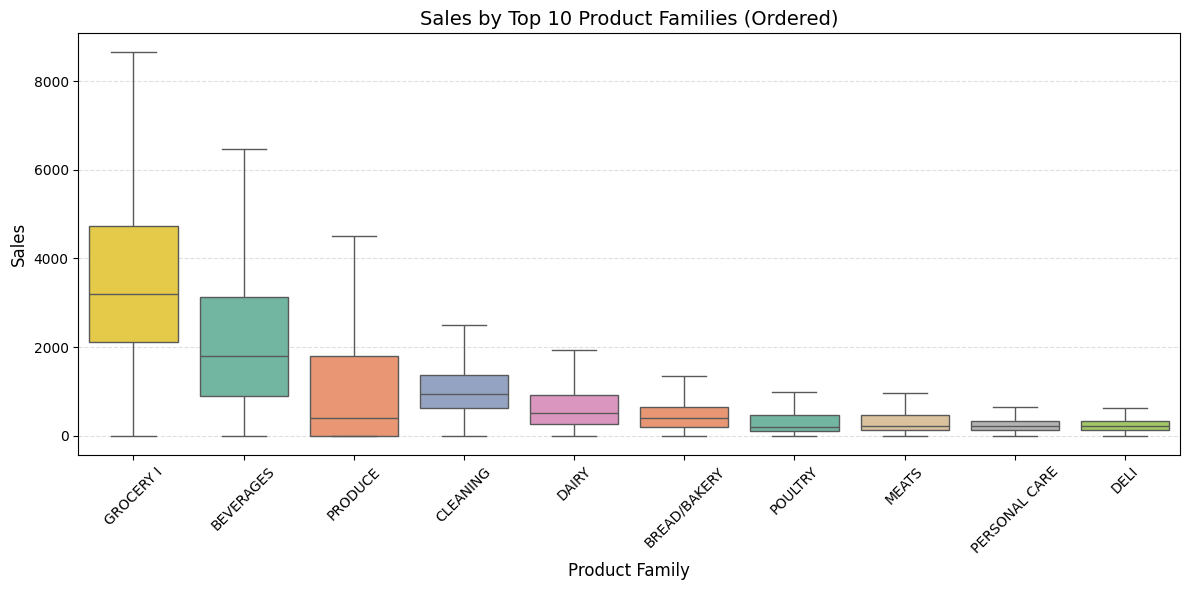

In [25]:
# Make sure 'family' is a string (not category)
train_merged['family'] = train_merged['family'].astype(str)

# Get top 10 families by total sales
top_10_families = (
    train_merged.groupby('family')['sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Filter data
filtered_df = train_merged[train_merged['family'].isin(top_10_families.index)].copy()

# Order families left-to-right by total sales
ordered_families = top_10_families.index.tolist()

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='family',
    y='sales',
    hue='family',              # explicitly set hue
    data=filtered_df,
    order=ordered_families,    # enforce order
    palette='Set2',
    showfliers=False
)

plt.legend([], [], frameon=False)  # hide legend
plt.title("Sales by Top 10 Product Families (Ordered)", fontsize=14)
plt.xlabel("Product Family", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


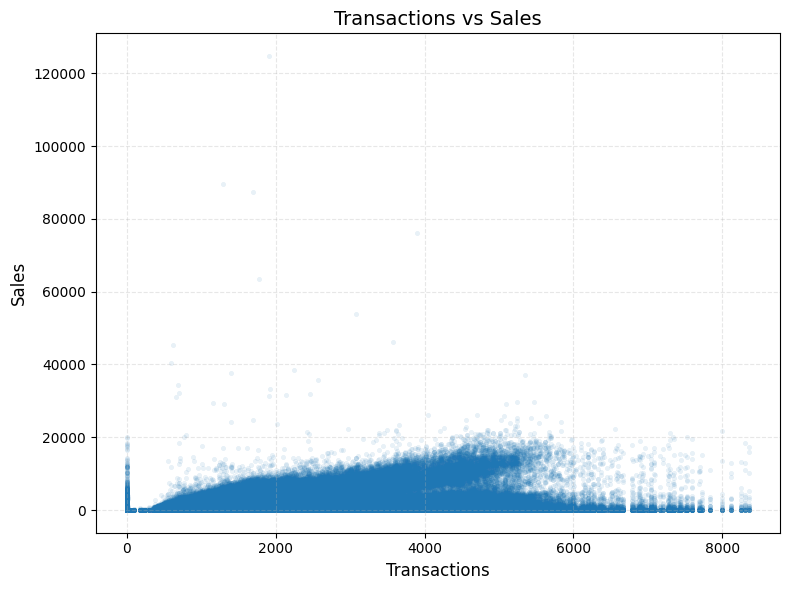

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='transactions',
    y='sales',
    data=train_merged,
    alpha=0.1,          # more transparent
    s=10,               # smaller points
    edgecolor=None
)

plt.title("Transactions vs Sales", fontsize=14)
plt.xlabel("Transactions", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()